## Assignment 6 by Agajan Torayev (matr.: 3067341), Joan Plepi (matr.: 3056655)

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

### Setup

In [2]:
batch_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
channels = 3
width = 32
height = 32

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# transformations for the image
# normalization: (x - mean) / std
means = (0.5, 0.5, 0.5)
stds = (0.5, 0.5, 0.5)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                      shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

print("Train set size: {}, Test set size: {}".format(len(trainset), len(testset)))

if not os.path.exists('./convdae'):
    os.mkdir('./convdae')

def to_img(x, channels, width, height, mean=0.5, std=0.5):
    x = std * x + mean
    x = x.clamp(0, 1)
    return x

def add_noise(img, a=-1.0, b=1.0, th=0.1):
    noise = torch.randn(img.shape)
    return torch.clamp(img + th * noise, a, b)

Files already downloaded and verified
Files already downloaded and verified
Train set size: 50000, Test set size: 10000


### ConvDAE - Convolutional Denoising Auto Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), # batch x 32 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), # batch x 32 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), # batch x 64 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), # batch x 64 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2) # batch x 64 x 16 x 16
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), # batch x 128 x 16 x 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), # batch x 128 x 16 x 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2), # batch x 128 x 8 x 8
            nn.Conv2d(128, 256, 3, padding=1), # batch x 256 x 8 x 8
            nn.ReLU()
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

# w_out = (w_in - 1) * stride - 2 * padding + kernel + output_padding
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), # batch x 128 x 16 x 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1, output_padding=0), # batch x 128 x 16 x 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # batch x 64 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1, output_padding=0), # batch x 64 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1, output_padding=0), # batch x 32 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1, output_padding=0), # batch x 32 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1, output_padding=0) # batch x 3 x 32 x 32
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

### Check Autoencoder dimensions

In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

for image, label in trainloader:
    image = image.cuda()
    output = encoder(image)
    print(output.size())
    output = decoder(output)
    print(output.size())
    break

torch.Size([100, 256, 8, 8])
torch.Size([100, 3, 32, 32])


### Train ConvDAE

In [5]:
num_epochs = 10
lr = 1e-2

encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = list(encoder.parameters()) + list(decoder.parameters())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=lr)

for epoch in range(num_epochs):
    start = time.time()
    
    for images, labels  in trainloader:
        noisy_images = add_noise(images)
        
        images = images.to(device)
        noisy_images = noisy_images.to(device)
        
        # forward pass
        outputs = encoder(noisy_images)
        outputs = decoder(outputs)
        
        loss = criterion(outputs, images) # compare with original image not noisy!
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
    
    end = time.time()
    print("Epoch: {}\{}, loss: {:.4f}, epoch time: {:.4f} seconds.".format(epoch + 1, 
                                                                           num_epochs, 
                                                                           loss.item(), 
                                                                           end - start))
    if epoch % 2 == 0:
        img = to_img(outputs.cpu().data, channels, width, height)
        save_image(img, 'convdae/image_{}.png'.format(epoch + 1))

Epoch: 1\10, loss: 0.0229, epoch time: 34.7065 seconds.
Epoch: 2\10, loss: 0.0142, epoch time: 34.5653 seconds.
Epoch: 3\10, loss: 0.0110, epoch time: 34.7229 seconds.
Epoch: 4\10, loss: 0.0105, epoch time: 34.5748 seconds.
Epoch: 5\10, loss: 0.0093, epoch time: 34.5028 seconds.
Epoch: 6\10, loss: 0.0072, epoch time: 34.5971 seconds.
Epoch: 7\10, loss: 0.0059, epoch time: 34.5806 seconds.
Epoch: 8\10, loss: 0.0065, epoch time: 34.5979 seconds.
Epoch: 9\10, loss: 0.0056, epoch time: 34.5356 seconds.
Epoch: 10\10, loss: 0.0077, epoch time: 34.6200 seconds.


### Save model

In [ ]:
torch.save([encoder,decoder],'./convdae/convdae.pkl')

### Load model

In [7]:
encoder, decoder = torch.load('./convdae/convdae.pkl')

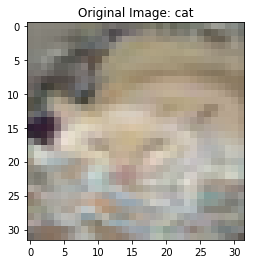

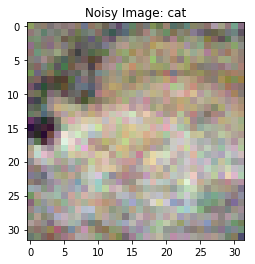

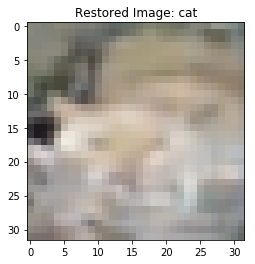

In [8]:
index = 1
orig_img = to_img(images[index].cpu(), channels, width, height)
orig_img = orig_img.data.numpy().transpose((1, 2, 0))

noisy_img = to_img(noisy_images[index].cpu(), channels, width, height)
noisy_img = noisy_img.data.numpy().transpose((1, 2, 0))

output_img = to_img(outputs[index].cpu(), channels, width, height)
output_img = output_img.data.numpy().transpose((1, 2, 0))

label = classes[labels[index]]

plt.title('Original Image: ' + label)
plt.imshow(orig_img)
plt.show()

plt.title('Noisy Image: ' + label)
plt.imshow(noisy_img)
plt.show()

plt.title('Restored Image: ' + label)
plt.imshow(output_img)
plt.show()

### CIFAR 10 Classification with Latent Space Representations

<ol>
    <li>Convert all training set to latent space representations  using Encoder.</li>
    <li>Convert all test set to latent space representations using Encoder.</li>
    <li>Train a classifier on training latent space representations set.</li>
    <li>Test a classifier on test latent space representations set.</li>
</ol>

In [9]:
def to_latent_space(x, channels, width, height, encoder, device):
    with torch.no_grad():
        x = x.view(1, channels, width, height).to(device)
        lx = encoder(x)   
    return lx.view(lx.shape[1:])

In [10]:
latent_train = []
latent_test = []

with torch.no_grad():
    for images, labels in trainloader:
        images = images.to(device)
        outputs = encoder(images)
        latent_train.append((outputs, labels))

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = encoder(images)
        latent_test.append((outputs, labels))

In [11]:
# bactch x 256 x 8 x 8
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1), # batch x 256 x 8 x 8
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1), # batch x 256 x 8 x 8
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=0), # batch x 256 x 6 x 6
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, 3, stride=1, padding=1), # batch x 128 x 6 x 6
            nn.MaxPool2d(2, stride=1) # batch x 128 x 5 x 5
        ) 
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 5 * 5, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )
    
    def forward(self, x):
        out = self.conv(x),
        out = out[0].view(out[0].size(0), -1)
        out = self.fc(out)
        return out

### Helper functions

In [12]:
def train(trainloader, model, optimizer, criterion, device, epochs,
          validloader=None, l1_reg=0, l2_reg=0):
    """Trains model on a given trainloader."""
    model.train()
    model.to(device)

    train_epoch_losses = []
    valid_epoch_losses = []
    train_iter_losses = []

    valid_epoch_accs = []
    
    for epoch in range(epochs):

        tic = time.time()
        loss_sum = 0.0

        for i, (images, labels) in enumerate(trainloader):

            # prepare inputs
            images, labels = images.to(device), labels.to(device)

            # forward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # record losses before regularization
            loss_sum += loss.item()
            train_iter_losses.append(loss.item())

            # add regularization loss, initialize to None for autograd
            l1_reg_loss = None
            l2_reg_loss = None
            for param in model.parameters():

                # add L1 regularization
                if l1_reg_loss is None:
                    l1_reg_loss = torch.sum(torch.abs(param))
                else:
                    l1_reg_loss = l1_reg_loss + torch.sum(torch.abs(param))

                # add L2 regularization
                if l2_reg_loss is None:
                    l2_reg_loss = 0.5 * param.norm(2) ** 2
                else:
                    l2_reg_loss = l2_reg_loss + 0.5 * param.norm(2) ** 2

            loss += l1_reg * l1_reg_loss
            loss += l2_reg * l2_reg_loss

            # backward
            loss.backward()
            optimizer.step()

        train_loss = loss_sum / (i + 1)
        train_epoch_losses.append(train_loss)

        # record validation accuracy per epoch if necessary
        if validloader is not None:
            valid_acc, valid_loss = test(validloader, model, criterion, device)
            valid_epoch_losses.append(valid_loss)
            valid_epoch_accs.append(valid_acc)

        print('Epoch: [{}/{}], total iters: {}, loss: {:.5f}, time: {:.5f} sec.'.format(epoch + 1,
                                                                                        epochs,
                                                                                        (epoch + 1) * (i + 1),
                                                                                        train_loss,
                                                                                        time.time() - tic))

    return train_epoch_losses, train_iter_losses, valid_epoch_losses, valid_epoch_accs


def test(testloader, model, criterion, device):
    """Tests the model on a given testset and returns all true and predicted labels."""
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs, pred_labels = torch.max(outputs.data, 1)
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)
            loss += criterion(outputs, labels).item()

    return 100 * correct / total, loss / (i + 1)

In [13]:
classifier = CNNClassifier()
classifier.to(device)

lr = 1e-4
epochs = 10

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train(latent_train, classifier, optimizer, criterion, device, epochs, l2_reg=0)

train_acc = test(latent_train, classifier, criterion, device)[0]
test_acc = test(latent_test, classifier, criterion, device)[0]
print("Training accuracy: {:.4f}, test accuracy: {:.4f}".format(train_acc, test_acc))

Epoch: [1/10], total iters: 500, loss: 1.44299, time: 17.22142 sec.
Epoch: [2/10], total iters: 1000, loss: 0.96114, time: 17.23578 sec.
Epoch: [3/10], total iters: 1500, loss: 0.77654, time: 17.14954 sec.
Epoch: [4/10], total iters: 2000, loss: 0.64100, time: 17.15781 sec.
Epoch: [5/10], total iters: 2500, loss: 0.52296, time: 17.28324 sec.
Epoch: [6/10], total iters: 3000, loss: 0.40624, time: 17.24503 sec.
Epoch: [7/10], total iters: 3500, loss: 0.30905, time: 17.12582 sec.
Epoch: [8/10], total iters: 4000, loss: 0.23297, time: 17.18991 sec.
Epoch: [9/10], total iters: 4500, loss: 0.18332, time: 17.27324 sec.
Epoch: [10/10], total iters: 5000, loss: 0.14616, time: 17.17310 sec.
Training accuracy: 88.8120, test accuracy: 71.9400
